In [403]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, mean_squared_error

import joblib
from fbprophet import Prophet


# Load data with all imputation

In [302]:
df = pd.read_csv('data/df_after_all_imputations.csv', date_parser=['Date'])
df.sort_values(by=['Location_ID', 'Date'], inplace=True)
df.reset_index(inplace=True);
df.drop(['Unnamed: 0', 'index'], axis=1, inplace=True)
print(df.iloc[:1,0].values)
df['Date'] = df['Date'].astype('datetime64[ns]')
print(df.iloc[:1,0].values)
location_id_all = list(df['Location_ID'].unique())[-2:]
# features_all = df.columns[2:-4][:2]
features_all = df.columns[2:-4]
print(df.shape)

['2008-07-01']
['2008-07-01T00:00:00.000000000']
(142193, 25)


In [406]:
len(features_all)

19

In [303]:
# назвать даты начала и окончания train (для одного Location_ID)
# подготовить train и test DF
def  train_test_split_ts(df, cur_Location_ID, name_f, \
                         d_train_start, d_train_end, period):
    name_d = 'Date'
    name_loc = 'Location_ID'
    d_test_start = d_train_end
    d_test_end = d_test_start + pd.Timedelta(period, unit='D')

    mask_train = (df[name_loc] == cur_Location_ID) & (df[name_d] >= d_train_start) & (df[name_d] < d_train_end)
    df_train = df[mask_train][[name_d, name_f]]
    df_train = df_train.rename(columns={name_d: 'ds', name_f: 'y'})

    mask_test = (df[name_loc] == cur_Location_ID) & (df[name_d] >= d_test_start) & (df[name_d] < d_test_end)
    df_test = df[mask_test][[name_d, name_f]]
    df_test = df_test.rename(columns={name_d: 'ds', name_f: 'y'})
    return df_train, df_test

def predict_prophet(df, period):
    m = Prophet(yearly_seasonality=True, daily_seasonality=False)
    m.fit(df)
    future = m.make_future_dataframe(periods=period)
    forecast = m.predict(future)
    return forecast, m

def preprocessing_befor_load(df):
    # convert dates
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df['year'] = df['Date'].dt.year.astype('uint16')
    df['month'] = df['Date'].dt.month.astype('uint8')
    df['season'] = df['month'].apply(lambda x: 1 if x in [1,11,12] else 
                                    2 if x in [3, 4, 5] else 
                                    3 if x in [6, 7, 8] else 4).astype('uint8')
    # replace wind directions with numeric
    wind_rose = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
    dict_replacer = dict(zip(wind_rose, range(len(wind_rose))))
    df.replace(dict_replacer, inplace=True)

    # drop
    df.drop(['Unnamed: 0', 'Date'], axis=1, inplace=True)
    return df

# best_model_file_name = 'models/tuNning/cat-tunning_model-[GridSearchCV][02-22-2020, 20-51-52].pkl'
# clf = joblib.load(best_model_file_name)
file_name_log2 = 'models/df_log2.pkl'
df_log2 = joblib.load(file_name_log2)
best_model_file_name = df_log2.sort_values(by=['roc_auc_test'], ascending=False).loc[:,'model'].to_list()[0]
print(best_model_file_name)
clf = joblib.load(best_model_file_name)

models/tunning\cat-tunning_model-[GridSearchCV][02-22-2020, 20-51-52].pkl


# Собираем датасет

In [ ]:
print(1/0)
# Собираем датасет
period = 14
d_train_start = '2015-10-01'
d_train_end = '2017-01-01'
# Для оценки предсказания нужно больше данных, начинаем смещаться на день вперед
iterations = 2
first_entrance = True
for i in range(iterations):
    d_train_start_cur = pd.Timestamp(d_train_start) + i*pd.Timedelta(1, unit='D')
    d_train_end_cur = pd.Timestamp(d_train_end) + i*pd.Timedelta(1, unit='D')
    temp_dict = {'Date': [d_train_end], 'Iteration': [0]}

    for location_id in location_id_all:
        temp_dict['Location_ID'] = [location_id]

        for feature in features_all:
            print(f'i -{i}, location_id - {location_id}, feature - {feature}')
            
            X_train, X_test = train_test_split_ts(df, cur_Location_ID = location_id, name_f=feature, \
                 d_train_start=d_train_start_cur, d_train_end=d_train_end_cur, period=period)
            forecast, m = predict_prophet(X_train, period)
            df_predict = forecast[['ds', 'yhat']]
            df_predict = df_predict[-period:]
            display(df_predict)
            for p in range(period):
                temp_dict[feature +'_'+ str(p)] = df_predict.iloc[p,1]
            break
        if first_entrance:
            main0 = pd.DataFrame.from_dict(temp_dict)
            first_entrance = False
        else:
            main_cur = pd.DataFrame.from_dict(temp_dict)
            main0 = pd.concat([main0, main_cur])
        print(main0.shape, X_test.shape)
#         break
#     break

In [384]:
# print(main0.shape)
# main0
# joblib.dump(main0, f'data/main0.joblib')
main0 = joblib.load(f'data/main_all_00-21.joblib')
main0

,Date,Iteration,Location_ID,Cloud9am_0,Cloud9am_1,Cloud9am_2,Cloud9am_3,Cloud9am_4,Cloud9am_5,Cloud9am_6,...,WindSpeed3pm_4,WindSpeed3pm_5,WindSpeed3pm_6,WindSpeed3pm_7,WindSpeed3pm_8,WindSpeed3pm_9,WindSpeed3pm_10,WindSpeed3pm_11,WindSpeed3pm_12,WindSpeed3pm_13
0,2017-01-01,0,0,4.149999,4.036589,4.379089,4.380735,4.274319,4.385369,4.009423,...,15.502171,14.851406,15.496200,14.536839,16.046006,15.658619,16.005729,15.623158,14.943287,15.561383
0,2017-01-01,0,1,5.044315,5.141440,5.405710,4.293672,5.232272,5.142485,5.698158,...,24.395308,24.038680,23.635738,26.787370,23.594938,21.406417,21.932356,21.384022,20.232211,19.099922
0,2017-01-01,0,2,3.205685,3.278723,2.823670,2.749334,3.023842,2.960861,3.227051,...,17.716932,17.542160,18.016412,18.310703,18.315689,19.469694,19.624148,18.949759,18.626672,18.919404
0,2017-01-01,0,3,5.897999,5.858021,5.925837,5.889184,6.559441,6.825719,6.833192,...,19.461468,19.102223,20.161171,20.225163,18.390227,18.707640,17.265005,15.660264,15.180987,16.202653
0,2017-01-01,0,4,4.611899,4.471754,4.326394,4.455986,4.428698,4.316569,4.450072,...,15.980262,16.079277,16.158751,14.203668,15.899959,16.167536,15.613985,16.228741,16.375529,16.489869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2017-01-22,21,44,6.086614,5.866671,5.736453,6.202469,5.886803,6.181351,6.307330,...,16.677670,15.331740,17.136480,16.354429,16.526768,18.161020,17.147667,17.920105,16.478241,18.180252
0,2017-01-22,21,45,6.419029,5.920392,5.487428,6.168192,6.580294,6.090932,6.514723,...,23.654654,21.886500,25.342061,21.002539,23.168694,24.762392,23.564896,23.994357,22.243922,25.714632
0,2017-01-22,21,46,4.143397,4.010303,3.982395,3.627977,3.824704,3.591503,3.430863,...,21.295304,22.002892,21.876599,21.972579,22.035898,22.201251,22.687858,22.560737,23.256745,23.087760
0,2017-01-22,21,47,5.837620,5.764234,5.481233,5.176080,5.324085,5.103330,4.775000,...,17.934386,18.441266,18.816119,19.086082,17.515915,20.378570,18.450429,19.696811,20.329812,20.789100


In [ ]:
period = 14
main = main0.copy()
list_iter_base = ['Date', 'Location_ID'] + [feature for feature in features_all]
for p in range(period):
    list_iter = ['Date', 'Location_ID'] + [feature +'_'+ str(p) for feature in features_all]
    temp_df = main[list_iter]
    print(len(list_iter), temp_df.shape)
    # делаем заглушку 
    temp_df['Unnamed: 0'] = temp_df['Location_ID']
    temp_df.rename(columns=dict(zip(list_iter,list_iter_base)), inplace=True)
    temp_df = preprocessing_befor_load(temp_df)
#     display(temp_df.T)
    y_pred_raintomorrow = clf.predict_proba(temp_df)[:, 1]
    main['y' +'_'+ str(p)] = y_pred_raintomorrow
#     print(y_pred_raintomorrow)
#     break

In [386]:
main

,Date,Iteration,Location_ID,Cloud9am_0,Cloud9am_1,Cloud9am_2,Cloud9am_3,Cloud9am_4,Cloud9am_5,Cloud9am_6,...,y_4,y_5,y_6,y_7,y_8,y_9,y_10,y_11,y_12,y_13
0,2017-01-01,0,0,4.149999,4.036589,4.379089,4.380735,4.274319,4.385369,4.009423,...,0.119067,0.092419,0.082708,0.099437,0.123856,0.138518,0.146239,0.139645,0.110140,0.104600
0,2017-01-01,0,1,5.044315,5.141440,5.405710,4.293672,5.232272,5.142485,5.698158,...,0.116769,0.150424,0.181807,0.150225,0.151703,0.184472,0.206835,0.186628,0.203464,0.222336
0,2017-01-01,0,2,3.205685,3.278723,2.823670,2.749334,3.023842,2.960861,3.227051,...,0.187996,0.229752,0.166117,0.206433,0.197232,0.196105,0.213007,0.276434,0.255999,0.257351
0,2017-01-01,0,3,5.897999,5.858021,5.925837,5.889184,6.559441,6.825719,6.833192,...,0.135973,0.099044,0.178532,0.085476,0.074965,0.089344,0.099010,0.100933,0.103253,0.110180
0,2017-01-01,0,4,4.611899,4.471754,4.326394,4.455986,4.428698,4.316569,4.450072,...,0.092472,0.150615,0.124208,0.146037,0.182388,0.163141,0.205285,0.199703,0.235174,0.198649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2017-01-22,21,44,6.086614,5.866671,5.736453,6.202469,5.886803,6.181351,6.307330,...,0.250618,0.292501,0.213682,0.267701,0.274854,0.250861,0.284504,0.248335,0.290014,0.166329
0,2017-01-22,21,45,6.419029,5.920392,5.487428,6.168192,6.580294,6.090932,6.514723,...,0.201589,0.201516,0.181821,0.182226,0.200018,0.148478,0.205766,0.165611,0.193386,0.140236
0,2017-01-22,21,46,4.143397,4.010303,3.982395,3.627977,3.824704,3.591503,3.430863,...,0.132200,0.120335,0.151274,0.147790,0.121027,0.108177,0.084821,0.101828,0.136705,0.121251
0,2017-01-22,21,47,5.837620,5.764234,5.481233,5.176080,5.324085,5.103330,4.775000,...,0.186515,0.167696,0.150707,0.195056,0.178742,0.111762,0.134120,0.129708,0.119972,0.108333


In [387]:
list_iter_y = ['Date', 'Location_ID'] + ['y_'+ str(p) for p in range(period)]
main_merge = main[list_iter_y]
display(main_merge)
df_merge = df[['Date', 'Location_ID', 'RainTomorrow']]
df_merge.rename(columns={'Date':'Date_temp'}, inplace=True)
display(df_merge.tail(2))

,Date,Location_ID,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10,y_11,y_12,y_13
0,2017-01-01,0,0.119967,0.129999,0.128740,0.116790,0.119067,0.092419,0.082708,0.099437,0.123856,0.138518,0.146239,0.139645,0.110140,0.104600
0,2017-01-01,1,0.101358,0.106802,0.122487,0.112046,0.116769,0.150424,0.181807,0.150225,0.151703,0.184472,0.206835,0.186628,0.203464,0.222336
0,2017-01-01,2,0.161598,0.174686,0.190404,0.167878,0.187996,0.229752,0.166117,0.206433,0.197232,0.196105,0.213007,0.276434,0.255999,0.257351
0,2017-01-01,3,0.134091,0.106210,0.119334,0.106588,0.135973,0.099044,0.178532,0.085476,0.074965,0.089344,0.099010,0.100933,0.103253,0.110180
0,2017-01-01,4,0.090535,0.150487,0.083484,0.083736,0.092472,0.150615,0.124208,0.146037,0.182388,0.163141,0.205285,0.199703,0.235174,0.198649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2017-01-22,44,0.197209,0.223443,0.195917,0.236361,0.250618,0.292501,0.213682,0.267701,0.274854,0.250861,0.284504,0.248335,0.290014,0.166329
0,2017-01-22,45,0.219793,0.280961,0.189320,0.244026,0.201589,0.201516,0.181821,0.182226,0.200018,0.148478,0.205766,0.165611,0.193386,0.140236
0,2017-01-22,46,0.121541,0.142054,0.118133,0.095748,0.132200,0.120335,0.151274,0.147790,0.121027,0.108177,0.084821,0.101828,0.136705,0.121251
0,2017-01-22,47,0.263500,0.208057,0.190287,0.181854,0.186515,0.167696,0.150707,0.195056,0.178742,0.111762,0.134120,0.129708,0.119972,0.108333


C:\Users\makag\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date_temp,Location_ID,RainTomorrow
142191,2017-06-23,48,0
142192,2017-06-24,48,0


In [388]:
main_merge

,Date,Location_ID,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10,y_11,y_12,y_13
0,2017-01-01,0,0.119967,0.129999,0.128740,0.116790,0.119067,0.092419,0.082708,0.099437,0.123856,0.138518,0.146239,0.139645,0.110140,0.104600
0,2017-01-01,1,0.101358,0.106802,0.122487,0.112046,0.116769,0.150424,0.181807,0.150225,0.151703,0.184472,0.206835,0.186628,0.203464,0.222336
0,2017-01-01,2,0.161598,0.174686,0.190404,0.167878,0.187996,0.229752,0.166117,0.206433,0.197232,0.196105,0.213007,0.276434,0.255999,0.257351
0,2017-01-01,3,0.134091,0.106210,0.119334,0.106588,0.135973,0.099044,0.178532,0.085476,0.074965,0.089344,0.099010,0.100933,0.103253,0.110180
0,2017-01-01,4,0.090535,0.150487,0.083484,0.083736,0.092472,0.150615,0.124208,0.146037,0.182388,0.163141,0.205285,0.199703,0.235174,0.198649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2017-01-22,44,0.197209,0.223443,0.195917,0.236361,0.250618,0.292501,0.213682,0.267701,0.274854,0.250861,0.284504,0.248335,0.290014,0.166329
0,2017-01-22,45,0.219793,0.280961,0.189320,0.244026,0.201589,0.201516,0.181821,0.182226,0.200018,0.148478,0.205766,0.165611,0.193386,0.140236
0,2017-01-22,46,0.121541,0.142054,0.118133,0.095748,0.132200,0.120335,0.151274,0.147790,0.121027,0.108177,0.084821,0.101828,0.136705,0.121251
0,2017-01-22,47,0.263500,0.208057,0.190287,0.181854,0.186515,0.167696,0.150707,0.195056,0.178742,0.111762,0.134120,0.129708,0.119972,0.108333


In [389]:
for p in range(period):
    part_str = '_'+ str(p)
#     main_merge['Date'+ part_str] = pd.Timestamp(main_merge['Date']) + p*pd.Timedelta(1, unit='D')
    main_merge['Date'+ part_str] = pd.to_datetime(main_merge['Date'], format='%Y-%m-%d') + p*pd.Timedelta(1, unit='D')
#     pd.to_datetime(main_merge['Date'], format='%Y-%m-%d')
#     display(main_merge)
    main_merge = pd.merge(
        left=main_merge,
        right=df_merge,
        how='left',
#         on=['Date', 'Location_ID'],
        left_on=['Date' + part_str, 'Location_ID'],
        right_on=['Date_temp', 'Location_ID'],
    )
#     display(main_merge)
    main_merge.rename(columns={'RainTomorrow': 'y_true_'+ str(p)}, inplace=True)
    main_merge.drop(['Date_temp', 'Date' + part_str], axis=1, inplace=True)
#     display(main_merge)
#     break
main_merge

C:\Users\makag\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,Location_ID,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,...,y_true_4,y_true_5,y_true_6,y_true_7,y_true_8,y_true_9,y_true_10,y_true_11,y_true_12,y_true_13
0,2017-01-01,0,0.119967,0.129999,0.128740,0.116790,0.119067,0.092419,0.082708,0.099437,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,2017-01-01,1,0.101358,0.106802,0.122487,0.112046,0.116769,0.150424,0.181807,0.150225,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017-01-01,2,0.161598,0.174686,0.190404,0.167878,0.187996,0.229752,0.166117,0.206433,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,2017-01-01,3,0.134091,0.106210,0.119334,0.106588,0.135973,0.099044,0.178532,0.085476,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,NaN
4,2017-01-01,4,0.090535,0.150487,0.083484,0.083736,0.092472,0.150615,0.124208,0.146037,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,2017-01-22,44,0.197209,0.223443,0.195917,0.236361,0.250618,0.292501,0.213682,0.267701,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1074,2017-01-22,45,0.219793,0.280961,0.189320,0.244026,0.201589,0.201516,0.181821,0.182226,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1075,2017-01-22,46,0.121541,0.142054,0.118133,0.095748,0.132200,0.120335,0.151274,0.147790,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1076,2017-01-22,47,0.263500,0.208057,0.190287,0.181854,0.186515,0.167696,0.150707,0.195056,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [400]:
print(main_merge.shape)
# main_merge.dropna(axis=0)
main_merge = main_merge.dropna(axis=0)
print(main_merge.shape)

(920, 30)
(920, 30)


# 14 дней - оценки

In [404]:
for p in range(period):
    print('y_true_'+ str(p))
#     display(main_merge[["y_true_"+ str(p)]])
#     display(main_merge["y_" + str(p)])
    y_true = main_merge["y_true_"+ str(p)].to_list()
#     print(y_true)
#     y_true = [1, 0, 0, 0]
    y = main_merge["y_" + str(p)].to_list()
#     print(y)
    print(f' period - {p}, roc_auc {roc_auc_score(y_true, y)}')
#     mean_squared_error
    print(f' period - {p}, mean_squared_error {mean_squared_error(y_true, y)}')
    y = np.round(y)
    print(f' period - {p}, accuracy {accuracy_score(y_true, y)}')
#     break
# roc_auc_score()

y_true_0
 period - 0, roc_auc 0.6478024574669188
 period - 0, mean_squared_error 0.15264177021285746
 period - 0, accuracy 0.8032608695652174
y_true_1
 period - 1, roc_auc 0.6516841636815955
 period - 1, mean_squared_error 0.1541871700301607
 period - 1, accuracy 0.8
y_true_2
 period - 2, roc_auc 0.6412761355443404
 period - 2, mean_squared_error 0.15741689505142994
 period - 2, accuracy 0.7945652173913044
y_true_3
 period - 3, roc_auc 0.6225167978638808
 period - 3, mean_squared_error 0.1571529754785529
 period - 3, accuracy 0.7978260869565217
y_true_4
 period - 4, roc_auc 0.6186210700496415
 period - 4, mean_squared_error 0.15561614189583614
 period - 4, accuracy 0.8010869565217391
y_true_5
 period - 5, roc_auc 0.6140594439117929
 period - 5, mean_squared_error 0.14992982673117353
 period - 5, accuracy 0.8108695652173913
y_true_6
 period - 6, roc_auc 0.5918874436738998
 period - 6, mean_squared_error 0.14571626011620128
 period - 6, accuracy 0.8184782608695652
y_true_7
 period - 7, r

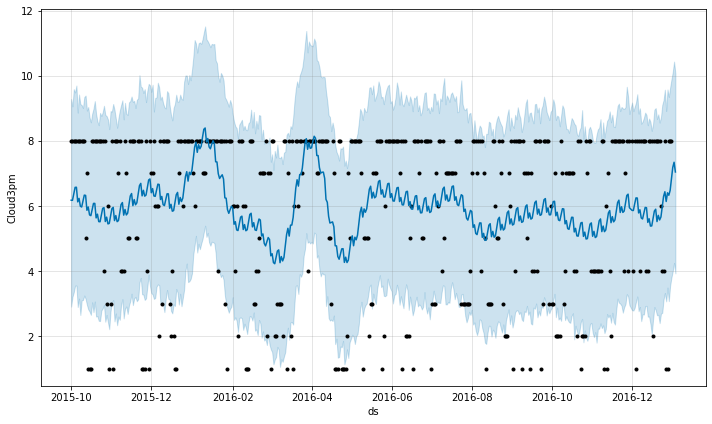

In [127]:
m.plot(forecast, ylabel=feature);

# Rainfall Prophet

In [128]:
X_train, X_test = train_test_split_ts(df, cur_Location_ID = location_id, name_f='Rainfall', \
     d_train_start=d_train_start_cur, d_train_end=d_train_end_cur, period=period)
print(X_train.shape, X_test.shape)
display(X_train.tail(2))
forecast_rainfall, m_rainfall = predict_prophet(X_train, period)
df_predict = forecast[['ds', 'yhat']]
df_predict = df_predict[-period:]
display(df_predict)

(457, 2) (3, 2)


,ds,y
139034,2016-12-30,0.0
139035,2016-12-31,0.4


,ds,yhat
457,2017-01-01,7.182920
458,2017-01-02,7.340988
459,2017-01-03,7.042550


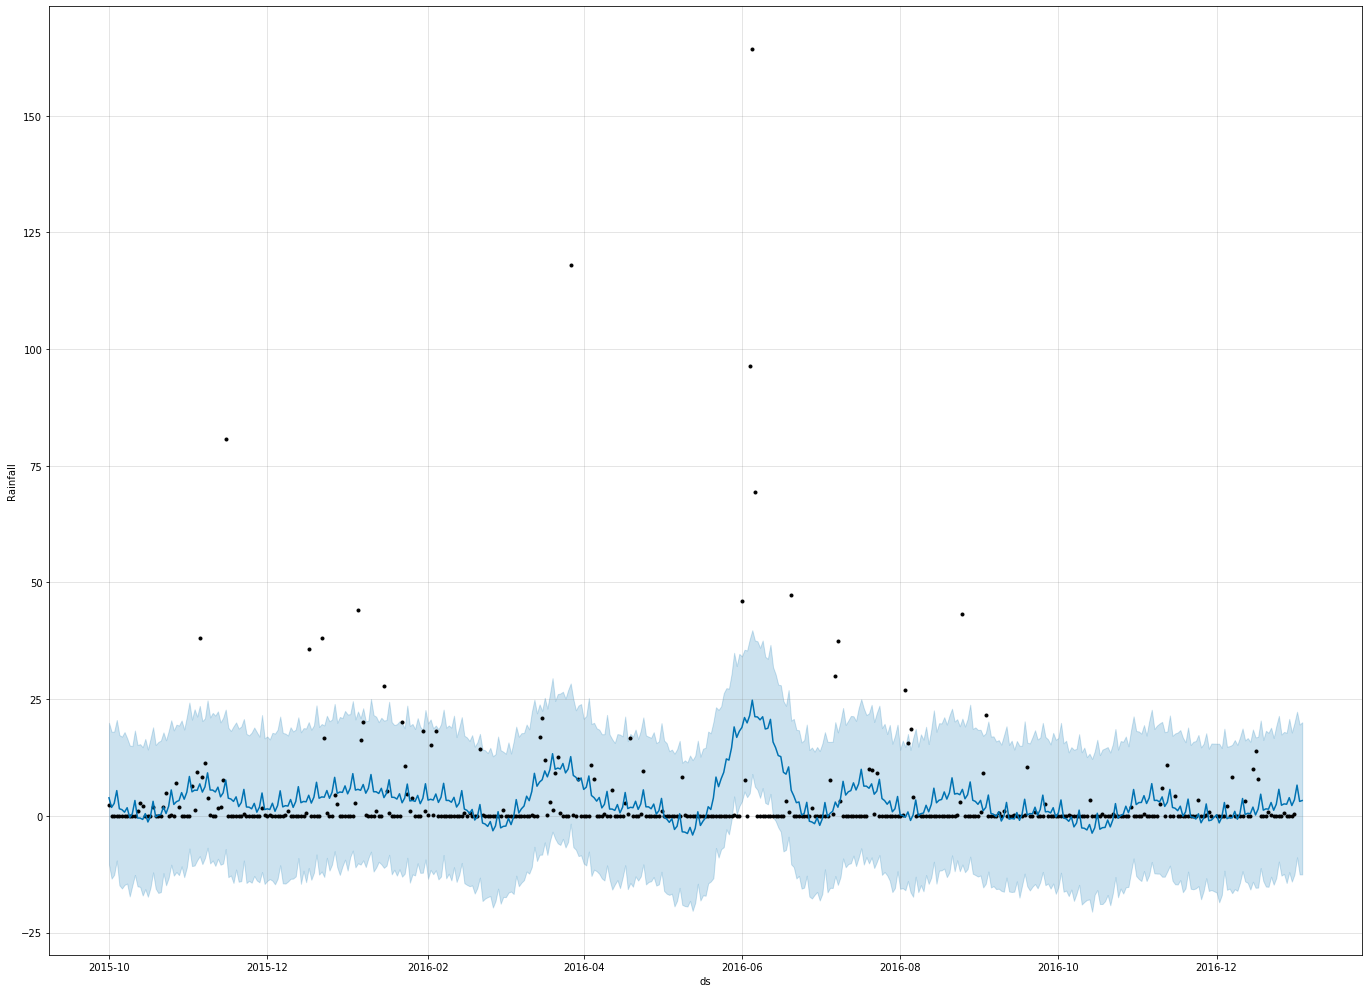

In [148]:
fig1 = m_rainfall.plot(forecast_rainfall, ylabel='Rainfall');
fig1.set_figwidth(20)
fig1.set_figheight(15)
